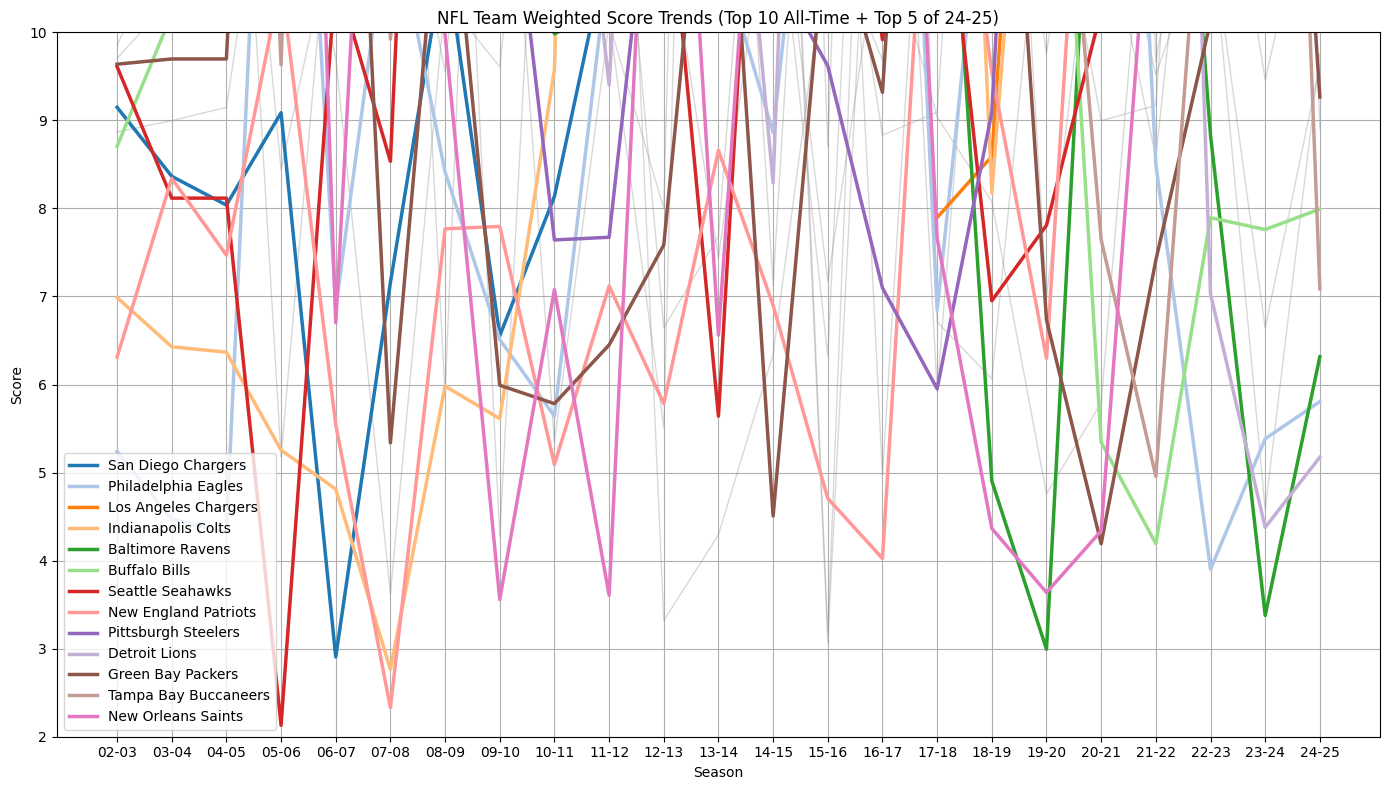

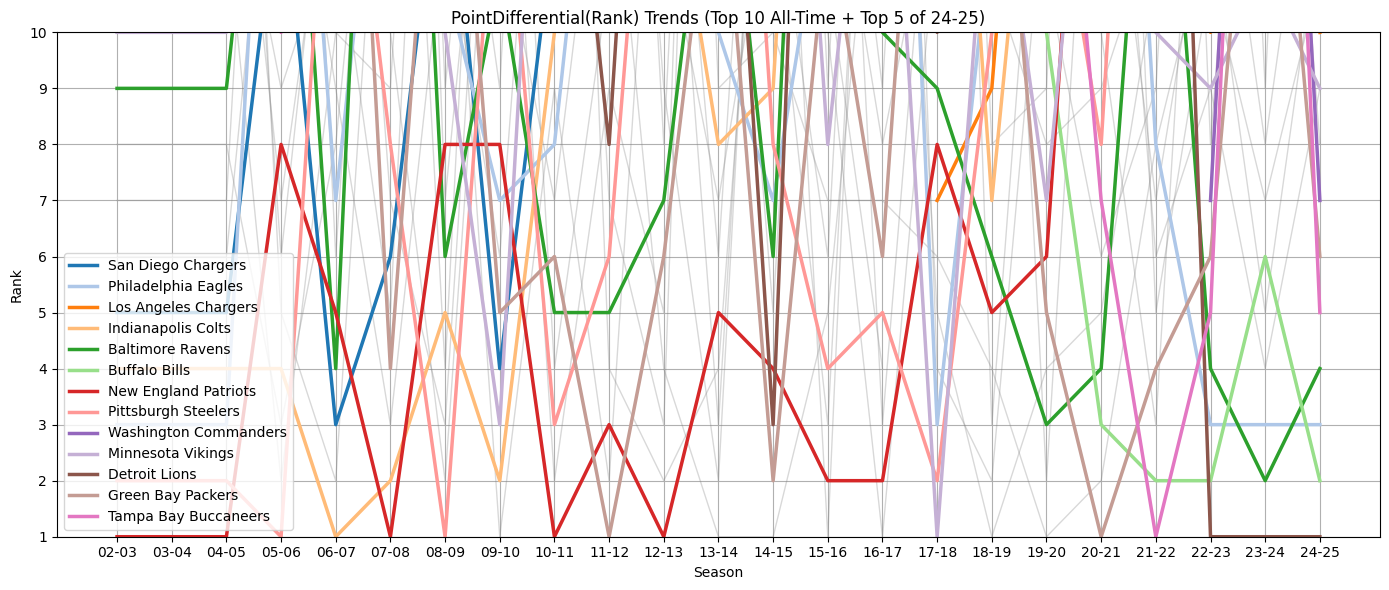

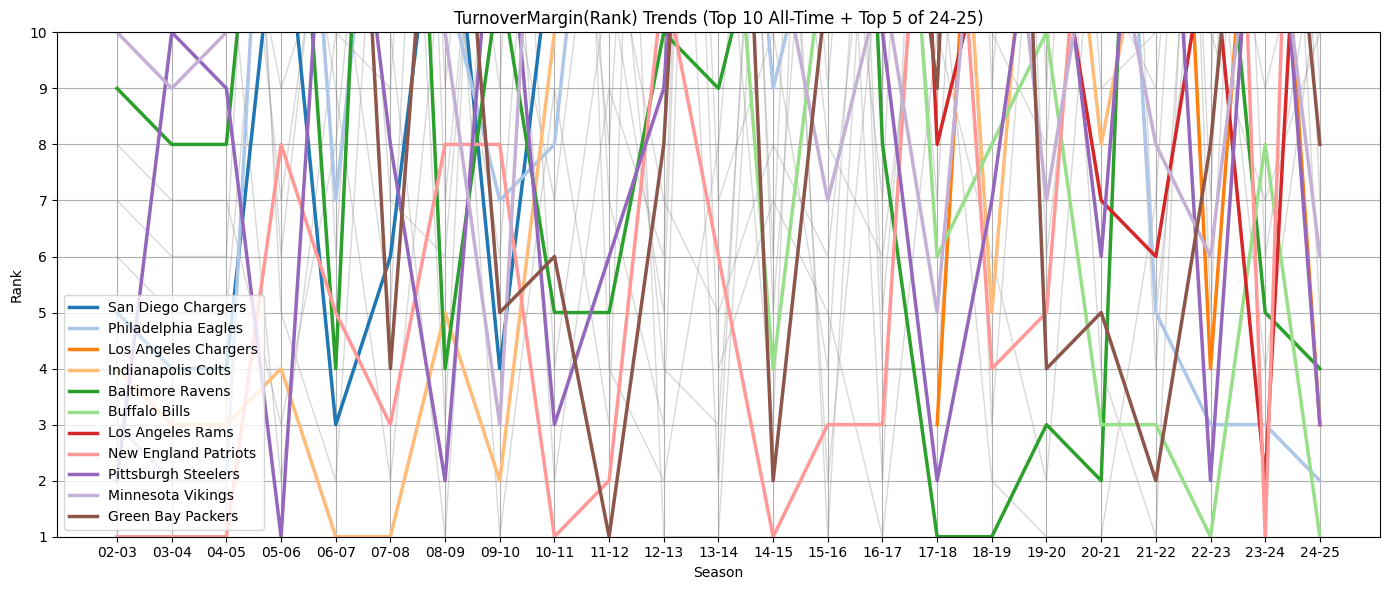

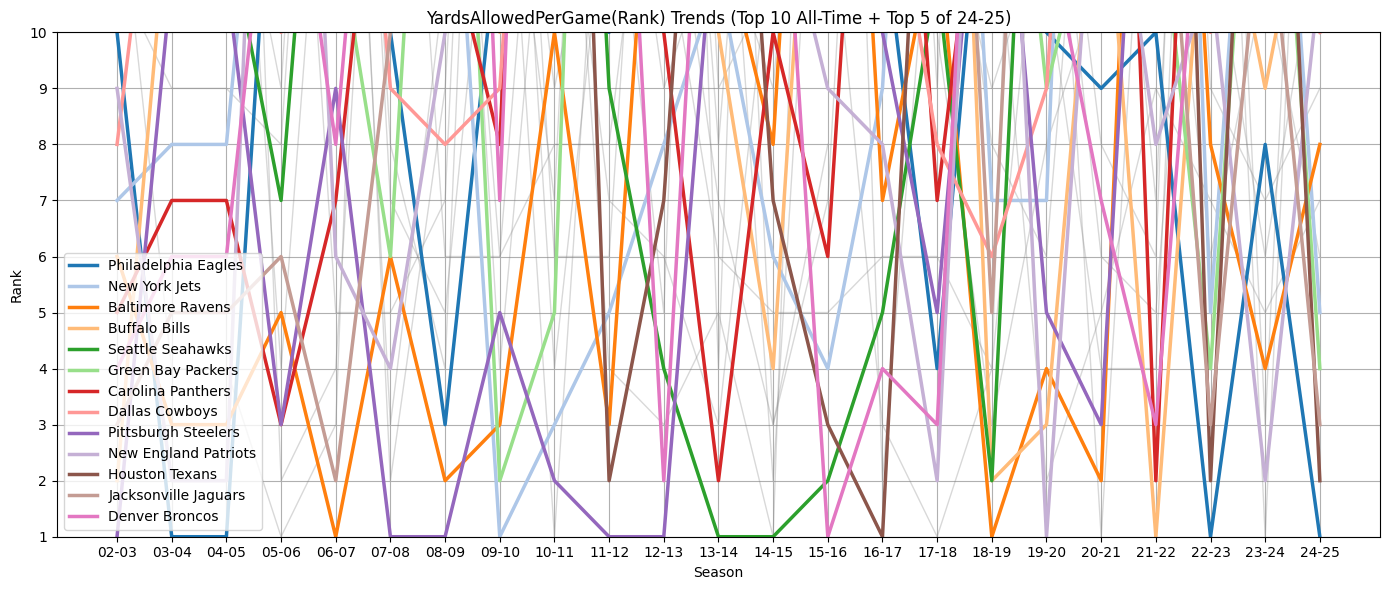

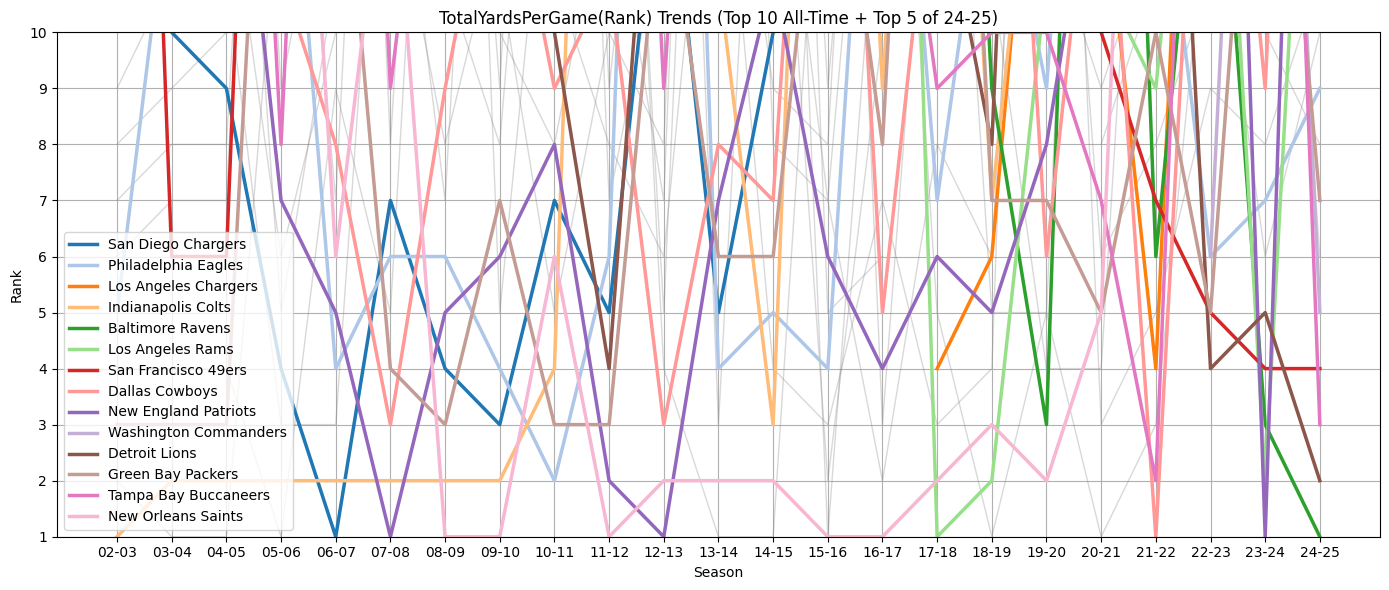

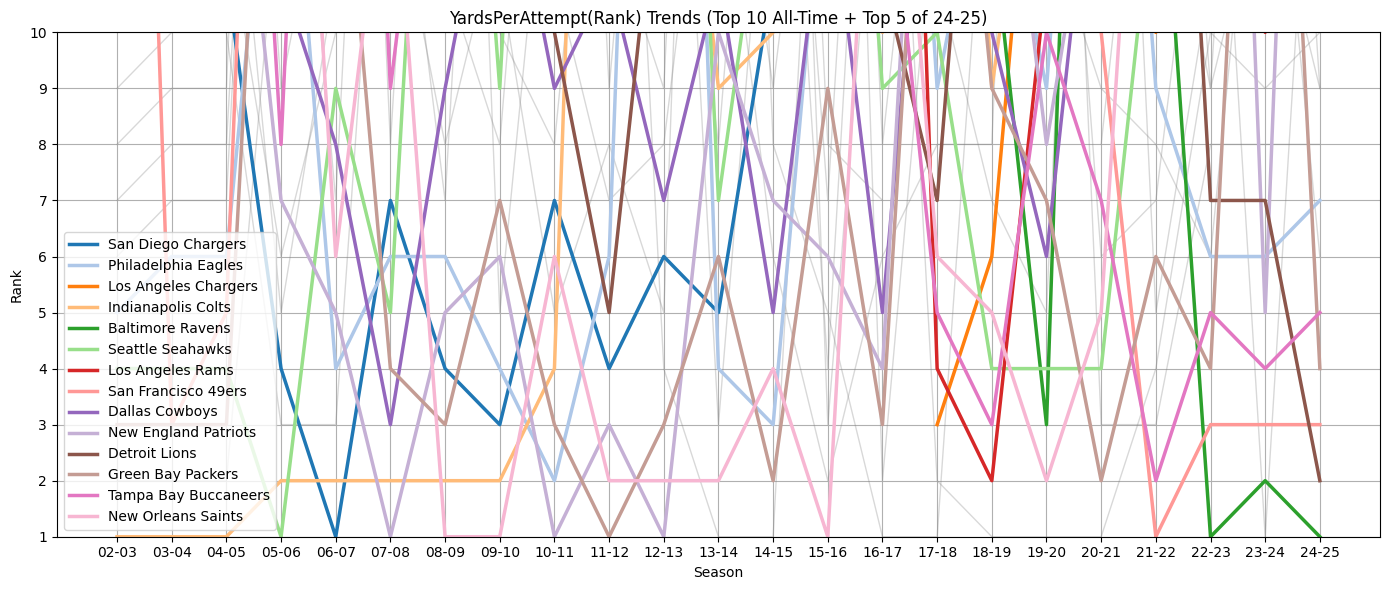

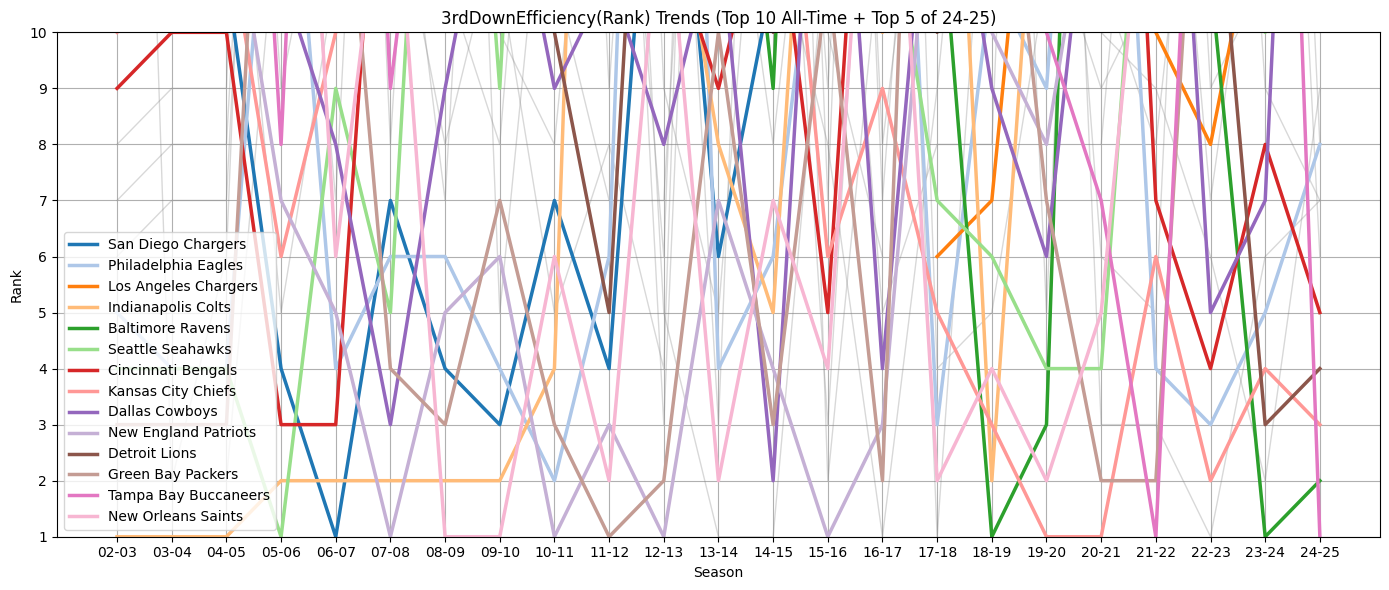

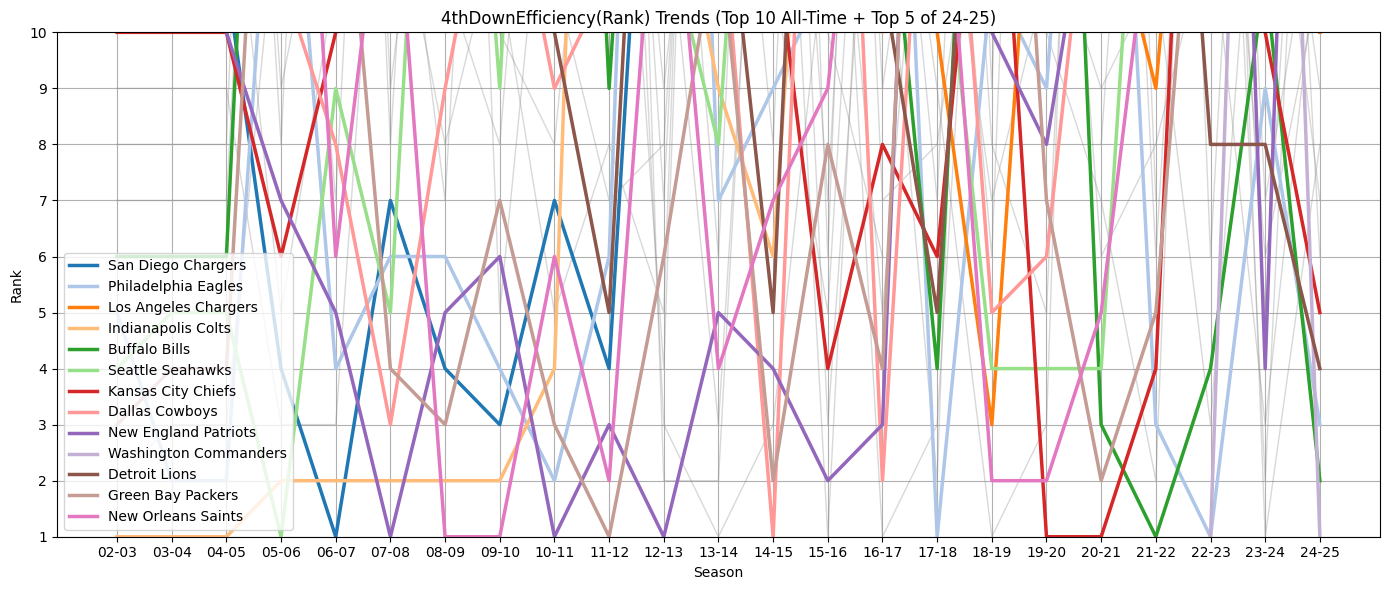

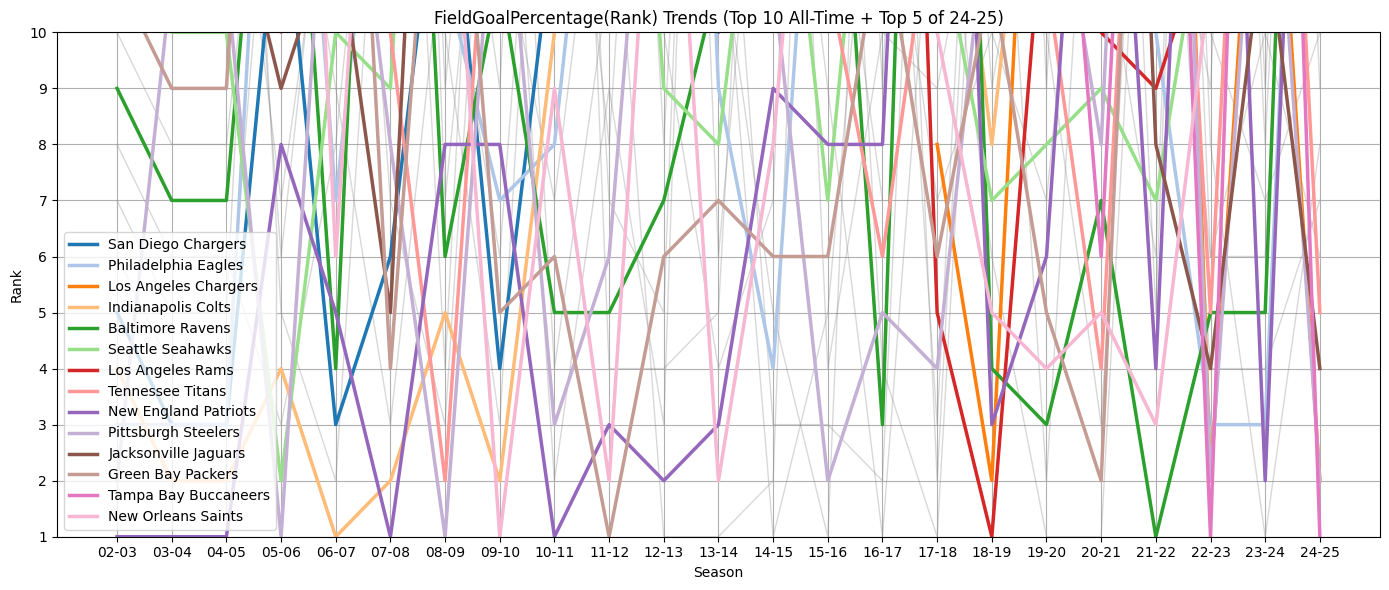

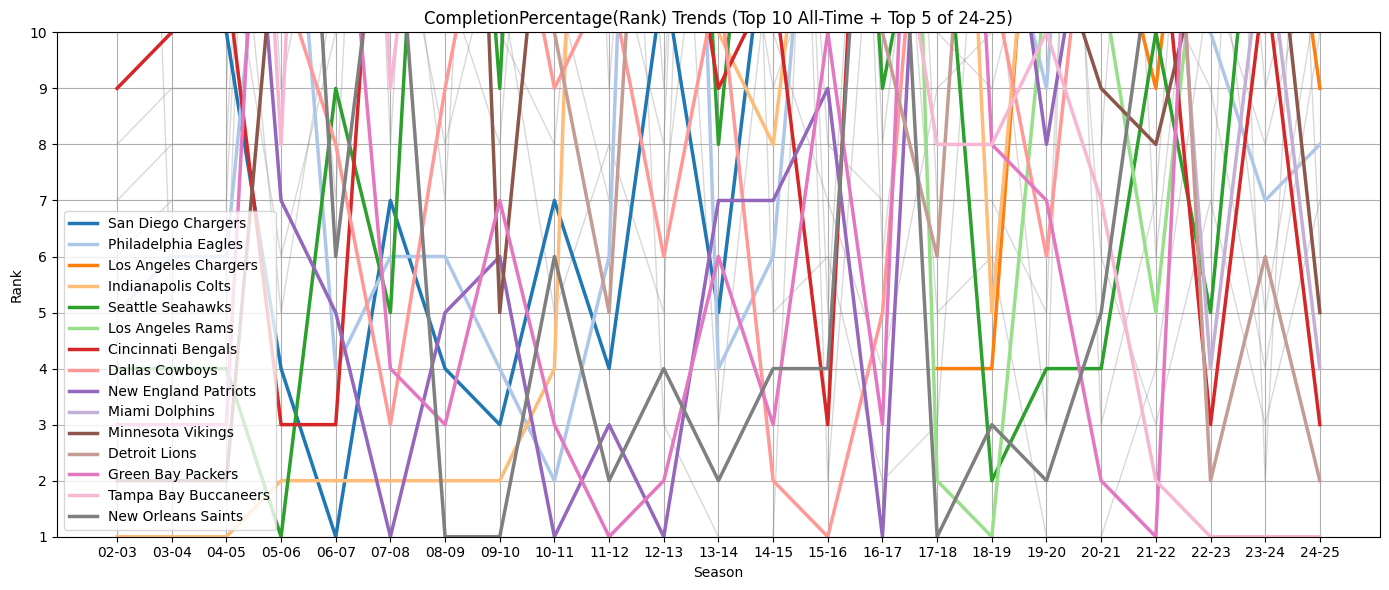

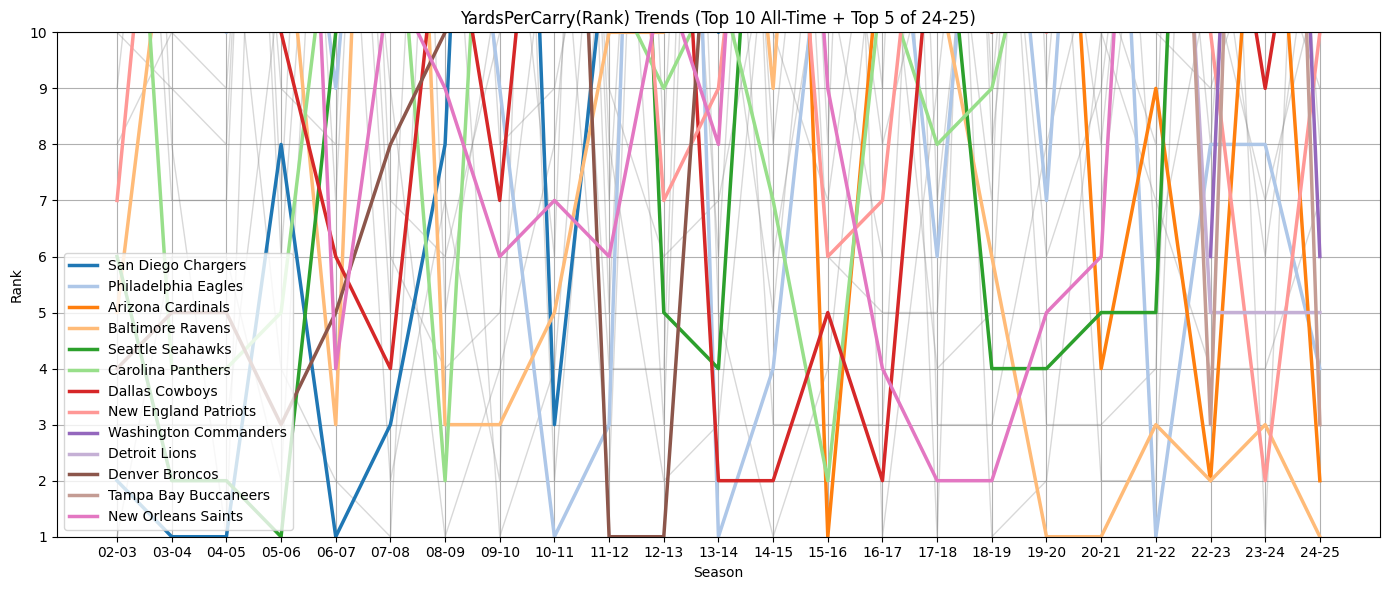

In [38]:
# 1. Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 2. Define Seasons and Weights
seasons = [
    '02-03', '03-04', '04-05', '05-06', '06-07', '07-08', '08-09',
    '09-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16',
    '16-17', '17-18', '18-19', '19-20', '20-21', '21-22', '22-23',
    '23-24', '24-25'
]
data_by_year = []

weights = {
    'PointDifferential(Rank)': 0.201375,
    'TurnoverMargin(Rank)': 0.150301,
    'YardsAllowedPerGame(Rank)': 0.118523,
    'TotalYardsPerGame(Rank)': 0.090575,
    'YardsPerAttempt(Rank)': 0.087150,
    '3rdDownEfficiency(Rank)': 0.085007,
    '4thDownEfficiency(Rank)': 0.072778,
    'FieldGoalPercentage(Rank)': 0.068099,
    'CompletionPercentage(Rank)': 0.064017,
    'YardsPerCarry(Rank)': 0.061366
}

# 3. Loop Through Each Year
all_stats_by_year = []
for season in seasons:
    filename = f"{season}nflstats.csv"
    df = pd.read_csv(filename)
    stat_columns = df.columns[1:]
    df[stat_columns] = df[stat_columns].apply(pd.to_numeric, errors='coerce')
    df['Score'] = df[weights.keys()].apply(
        lambda row: sum(row[col] * weights[col] for col in weights), axis=1)
    df['Year'] = season
    data_by_year.append(df[['Team', 'Score', 'Year']])
    all_stats_by_year.append(df[['Team', 'Year'] + list(weights.keys())])

# 4. Combine All Seasons
all_scores = pd.concat(data_by_year).groupby(['Year', 'Team'], as_index=False)['Score'].mean()
all_stats = pd.concat(all_stats_by_year).groupby(['Year', 'Team'], as_index=False).mean()

# 5. Plot Weighted Score Trends
pivot = all_scores.pivot(index='Year', columns='Team', values='Score')
team_means = pivot.mean().sort_values().head(10).index.tolist()
top_2024 = all_scores[all_scores['Year'] == '24-25'].sort_values('Score').head(5)['Team'].tolist()
highlight_teams = list(set(team_means + top_2024))

plt.figure(figsize=(14, 8))
colors = sns.color_palette("tab20", n_colors=len(highlight_teams))
for team in pivot.columns:
    plt.plot(pivot.index, pivot[team], color='gray', alpha=0.3, linewidth=1)
for i, team in enumerate(highlight_teams):
    if team in pivot.columns:
        plt.plot(pivot.index, pivot[team], label=team, linewidth=2.5, color=colors[i])
plt.title('NFL Team Weighted Score Trends (Top 10 All-Time + Top 5 of 24-25)')
plt.xlabel('Season')
plt.ylabel('Score')
plt.ylim(2, 10)
plt.legend(loc='lower left')
plt.tight_layout()
plt.grid(True)
plt.show()

# 6. Plot Individual Stat Trends
for stat in weights.keys():
    pivot_stat = all_stats.pivot(index='Year', columns='Team', values=stat)
    team_means_stat = pivot_stat.mean().sort_values().head(10).index.tolist()
    top_2024_stat = all_stats[all_stats['Year'] == '24-25'].sort_values(stat).head(5)['Team'].tolist()
    highlight_teams_stat = list(set(team_means_stat + top_2024_stat))

    plt.figure(figsize=(14, 6))
    colors = sns.color_palette("tab20", n_colors=len(highlight_teams_stat))
    for team in pivot_stat.columns:
        plt.plot(pivot_stat.index, pivot_stat[team], color='gray', alpha=0.3, linewidth=1)
    for i, team in enumerate(highlight_teams_stat):
        if team in pivot_stat.columns:
            plt.plot(pivot_stat.index, pivot_stat[team], label=team, linewidth=2.5, color=colors[i])

    plt.title(f'{stat} Trends (Top 10 All-Time + Top 5 of 24-25)')
    plt.xlabel('Season')
    plt.ylabel('Rank')
    plt.ylim(1, 10)
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.grid(True)
    plt.show()


In [39]:
# 7. Predicting Future Super Bowl Winner
sb_df = pd.read_csv("superbowlwinnerstats.csv")

# Extract rank values from formatted strings
def extract_rank(value):
    try:
        return int(value.split('(')[1].split(')')[0])
    except:
        return None

stat_cols = list(weights.keys())
for col in stat_cols:
    sb_df[col] = sb_df[col].apply(extract_rank)

# Calculate score for historical Super Bowl winners
sb_df['Score'] = sb_df[stat_cols].apply(
    lambda row: sum(row[col] * weights[col] for col in weights), axis=1)

superbowl_scores = sb_df[['Season', 'SuperBowlWinner', 'Score']]

# Merge with all_scores to compare winner rank
merged = all_scores.merge(superbowl_scores, left_on='Year', right_on='Season', how='inner')
merged['IsWinner'] = merged['Team'] == merged['SuperBowlWinner']
merged['Rank'] = merged.groupby('Season')['Score_x'].rank(method='min')

print("\nSuper Bowl Winners' Scores and Ranks:")
print(merged[merged['IsWinner']][['Season', 'SuperBowlWinner', 'Score_x', 'Rank']])

# Predict top candidates for 2024-25
latest = all_scores[all_scores['Year'] == '24-25'].sort_values('Score')
top_candidates = latest.head(5)
print("Top 5 Predicted 2024-25 Super Bowl Candidates:")
print(top_candidates)


Super Bowl Winners' Scores and Ranks:
Empty DataFrame
Columns: [Season, SuperBowlWinner, Score_x, Rank]
Index: []
Top 5 Predicted 2024-25 Super Bowl Candidates:
      Year                  Team     Score
714  24-25         Detroit Lions  5.175109
729  24-25   Philadelphia Eagles  5.806940
706  24-25      Baltimore Ravens  6.315790
733  24-25  Tampa Bay Buccaneers  7.085724
707  24-25         Buffalo Bills  7.992423


Training Data Class Distribution:
Model Accuracy: 0.8043478260869565
              precision    recall  f1-score   support

           0       0.98      0.81      0.89       178
           1       0.08      0.50      0.14         6

    accuracy                           0.80       184
   macro avg       0.53      0.66      0.52       184
weighted avg       0.95      0.80      0.87       184

Model-Based Prediction for 2025-26 (simulated):
                  Year                   Team  PointDifferential(Rank)  \
707  25-26 (simulated)          Buffalo Bills                      2.0   
729  25-26 (simulated)    Philadelphia Eagles                      3.0   
735  25-26 (simulated)  Washington Commanders                      7.0   
716  25-26 (simulated)         Houston Texans                      8.0   
724  25-26 (simulated)      Minnesota Vikings                      9.0   

     TurnoverMargin(Rank)  YardsAllowedPerGame(Rank)  TotalYardsPerGame(Rank)  \
707                   1.0     

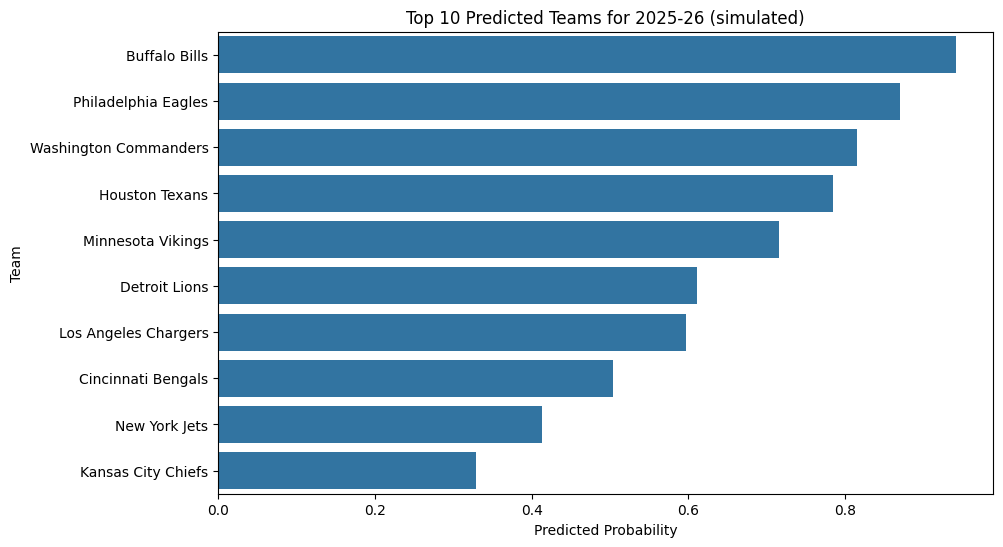

In [ ]:
# 8. Train Machine Learning Model (Logistic Regression)
# Prepare labeled training data
ml_df = all_stats.copy()
superbowl_scores = superbowl_scores.copy()
superbowl_scores['Season'] = superbowl_scores['Season'].apply(lambda s: s[-5:])
ml_df = ml_df.merge(superbowl_scores[['Season', 'SuperBowlWinner']], left_on='Year', right_on='Season', how='left')

# Normalize team names for matching
ml_df['Team'] = ml_df['Team'].str.replace(" ", "").str.lower()
ml_df['SuperBowlWinner'] = ml_df['SuperBowlWinner'].str.replace(" ", "").str.lower()
ml_df['IsWinner'] = ml_df['Team'] == ml_df['SuperBowlWinner']
ml_df = ml_df.drop(columns=['Season', 'SuperBowlWinner'])

X = ml_df[stat_cols]
y = ml_df['IsWinner'].astype(int)

print("Training Data Class Distribution:")
#print(y.value_counts())


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train, y_train)

print("Model Accuracy:", accuracy_score(y_test, clf.predict(X_test)))
print(classification_report(y_test, clf.predict(X_test)))

# Predict on 2025-26 season (simulate using 2024-25 data)
latest_stats = all_stats[all_stats['Year'] == '24-25'].copy()
latest_stats['Year'] = '25-26 (simulated)'

# Recalculate score with time-decay just for prediction context
recent_weight = 1.5
latest_stats['Score'] = latest_stats[stat_cols].apply(
    lambda row: recent_weight * sum(row[col] * weights[col] for col in weights), axis=1)
preds = clf.predict_proba(latest_stats[stat_cols])[:, 1]
latest_stats['PredictionProb'] = preds
print("Model-Based Prediction for 2025-26 (simulated):")
print(latest_stats.sort_values('PredictionProb', ascending=False).head(5))

plt.figure(figsize=(10,6))
sns.barplot(x='PredictionProb', y='Team', data=latest_stats.sort_values('PredictionProb', ascending=False).head(10))
plt.title('Top 10 Predicted Teams for 2025-26 (simulated)')
plt.xlabel('Predicted Probability')
plt.show()
